<a href="https://colab.research.google.com/github/RandivCosta/data-analysis/blob/main/Regression_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Regression Analysis

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
# data cleaning
data = pd.read_csv('adjusted_data.csv')
data.columns = data.columns.str.replace(r'[\(\)\- ]', '_', regex=True).str.lower()

# rename columns
column_rename = {
    'bc_enterococcus__cfu/100ml_': 'enterococcus',
    'bc_fecal_coliform_cfu/100ml_': 'fecal_coliform',
    'bc_e_coli__cfu/100ml_': 'e_coli',
    'pp_ph': 'ph',
    'pp_conductivity': 'conductivity',
    'pp_salinity': 'salinity',
    'pp_temperature': 'temperature',
    'ep_rainfall': 'rainfall',
    'ep_wind_speed': 'wind_speed'
}
data = data.rename(columns=column_rename)

# filtering
seawater = data[data['area'] == 'Sea Water']
sand = data[data['area'] == 'Sand']

output_dir = 'regression_results'
# output_dir_avg = 'regression_results_avg'
os.makedirs(output_dir, exist_ok=True)
# os.makedirs(output_dir_avg, exist_ok=True)

###site-specific regression analysis

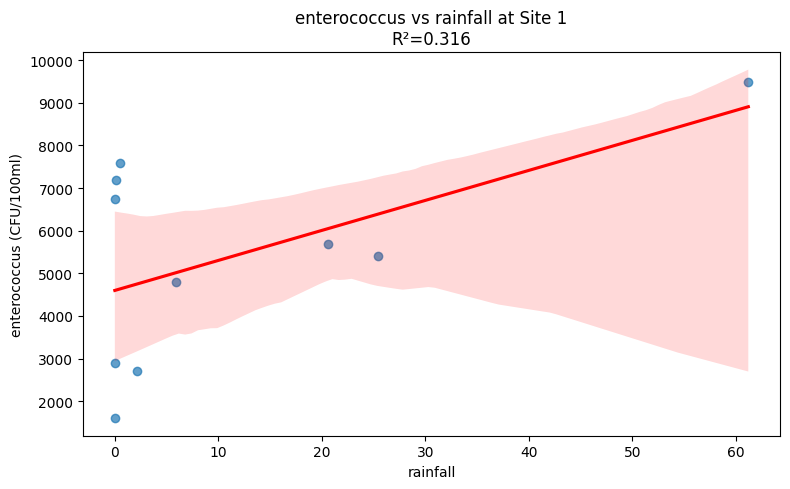

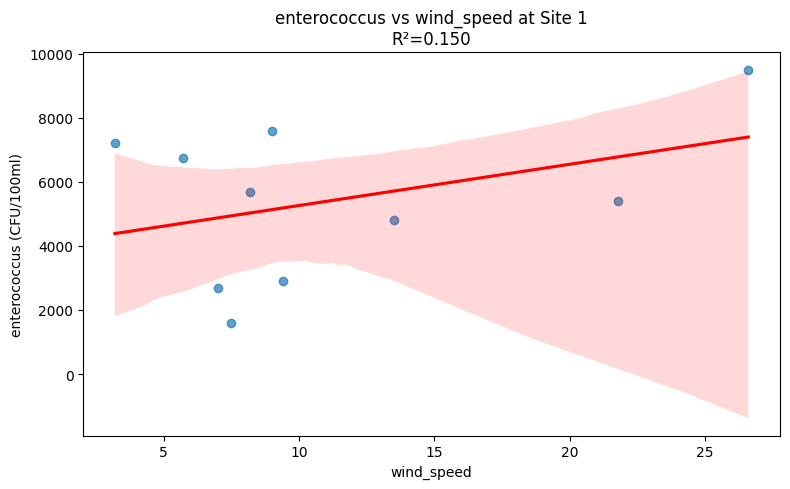

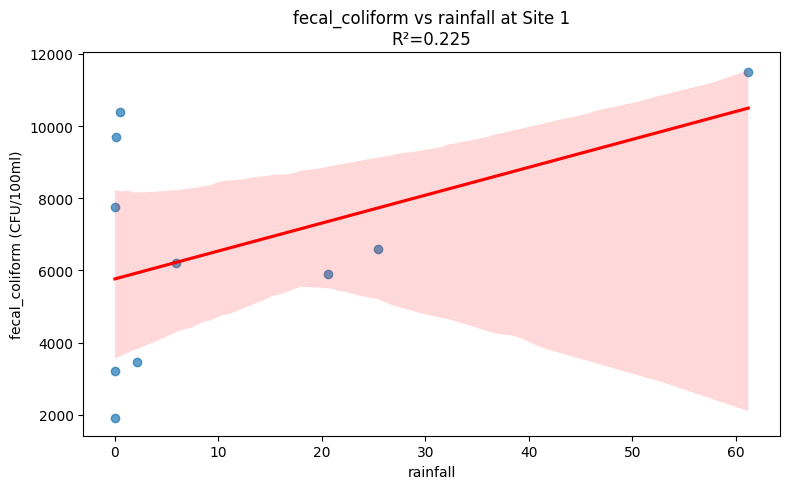

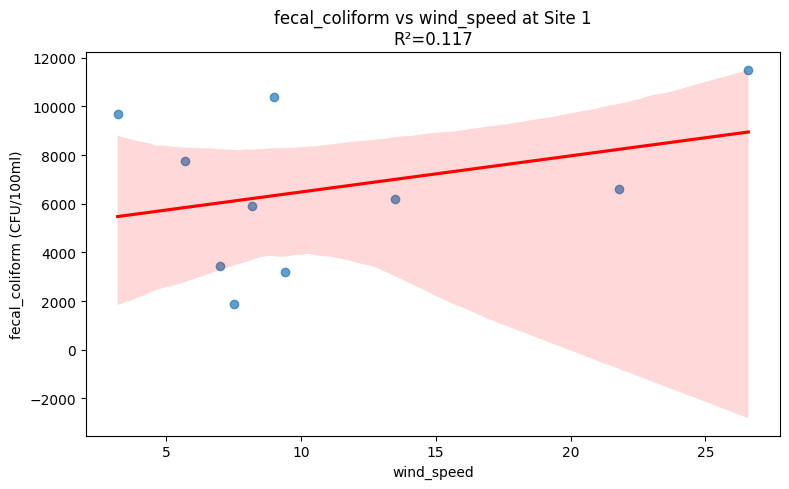

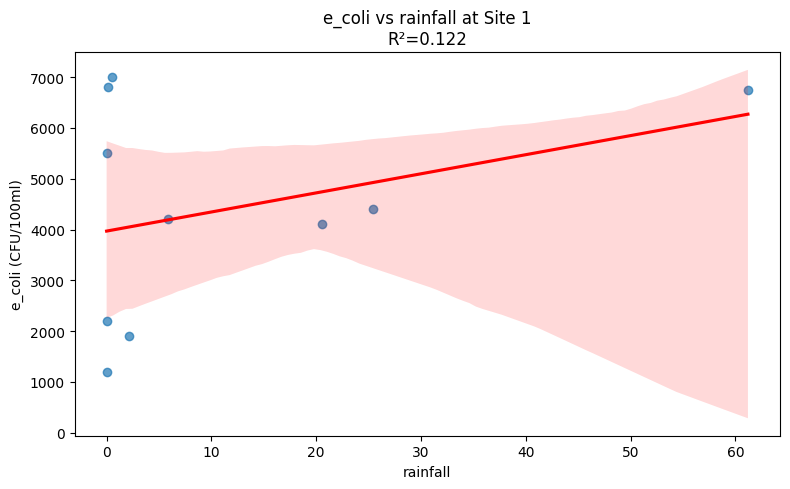

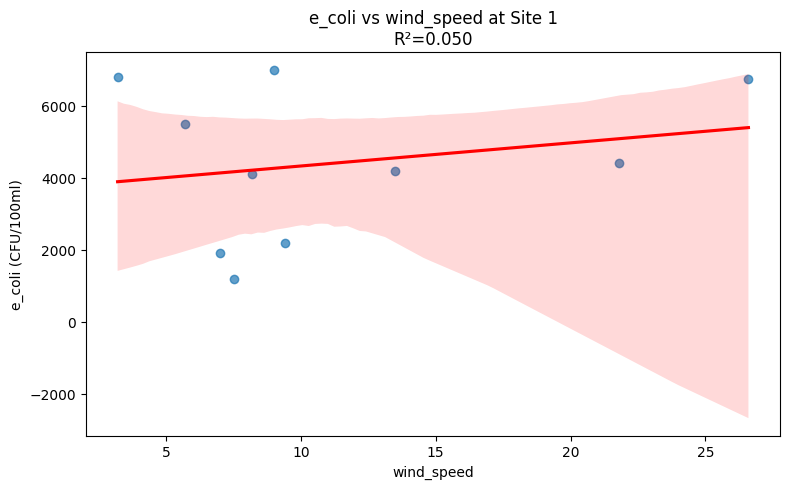

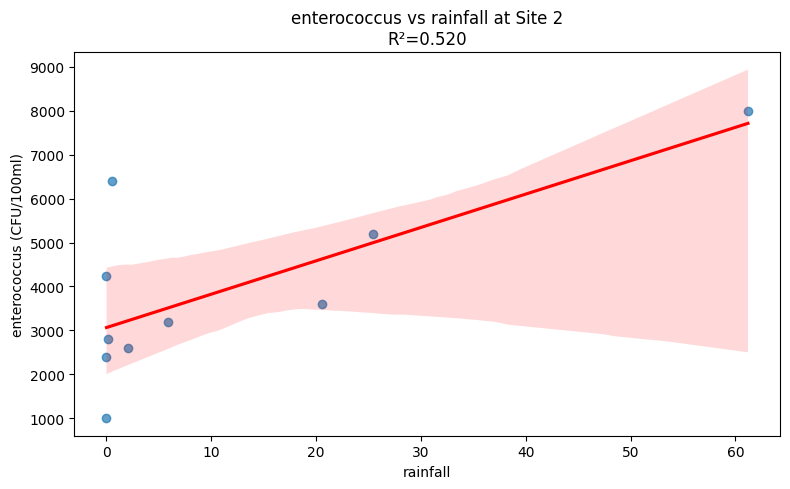

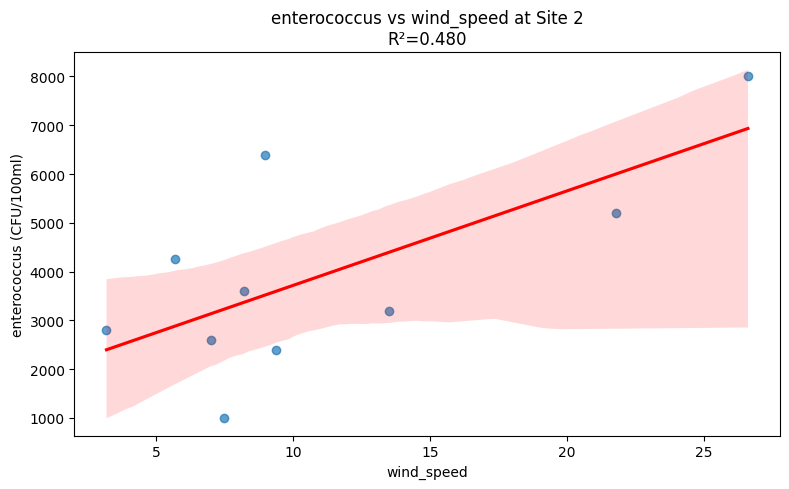

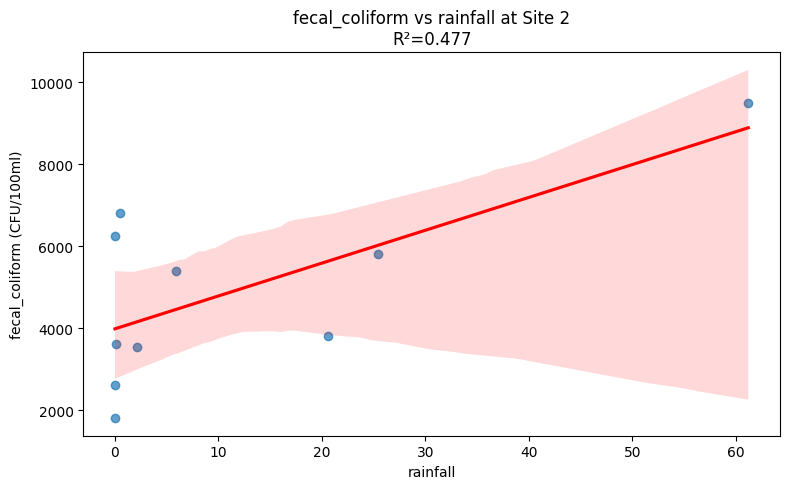

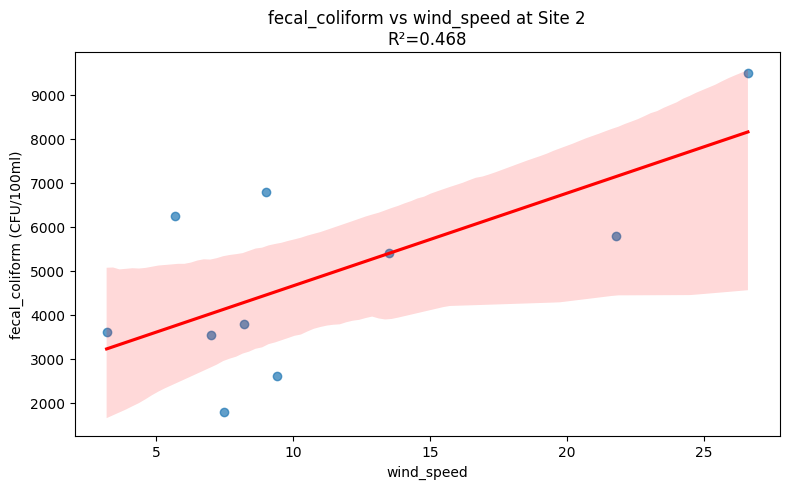

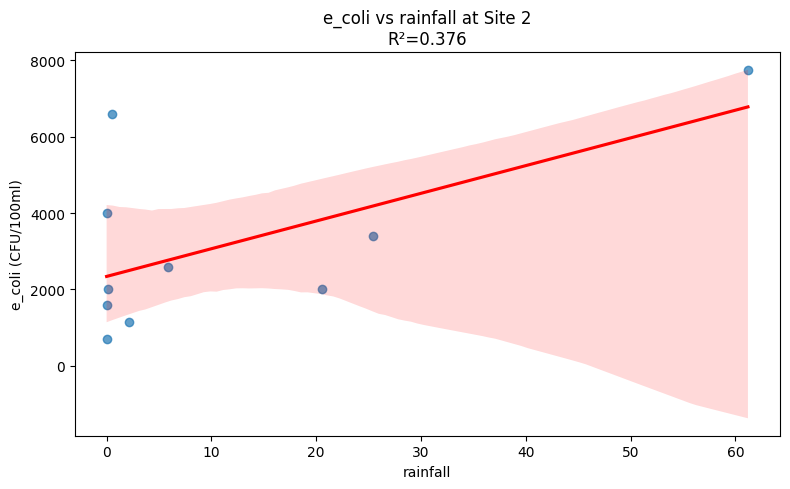

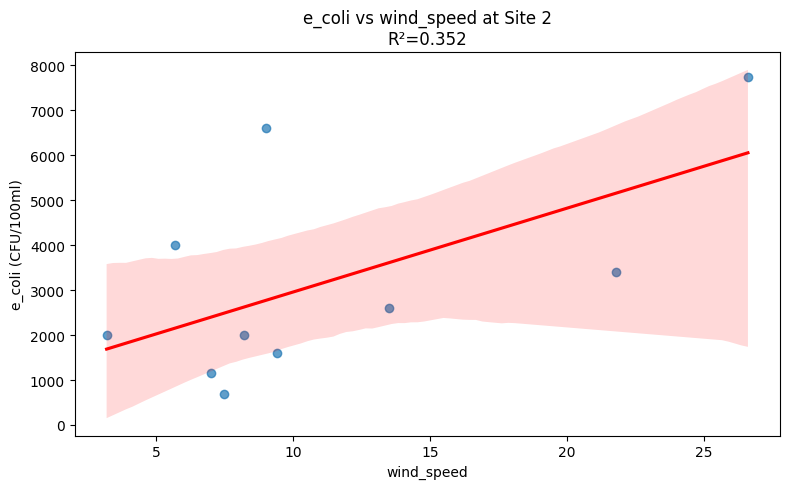

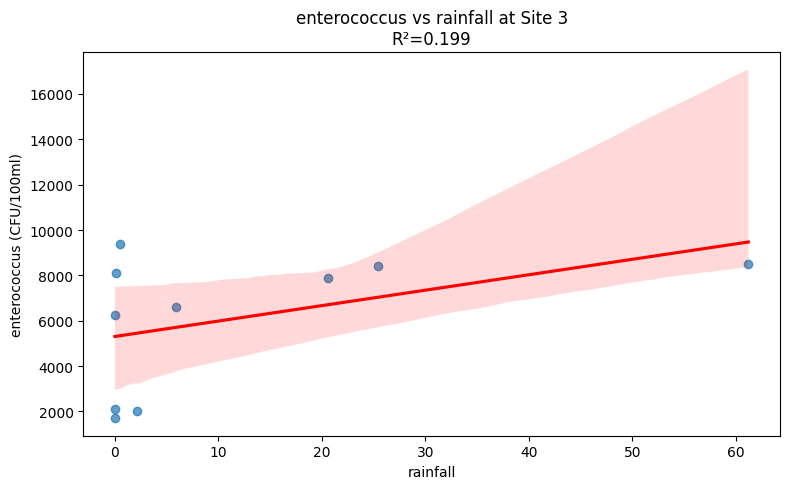

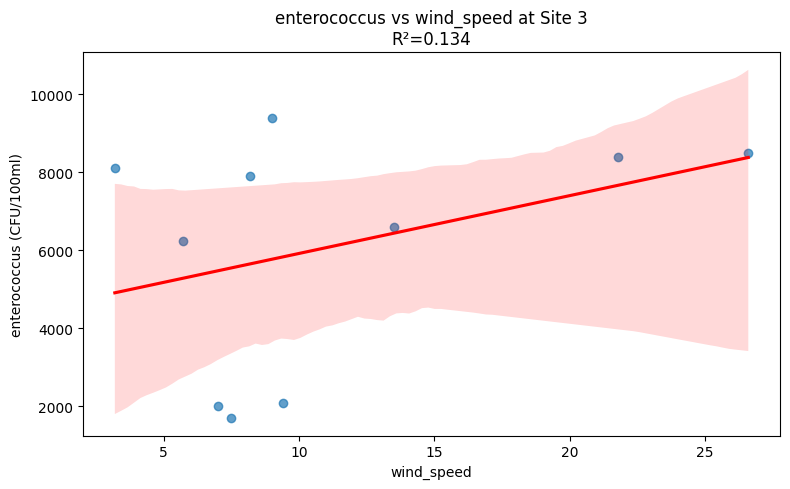

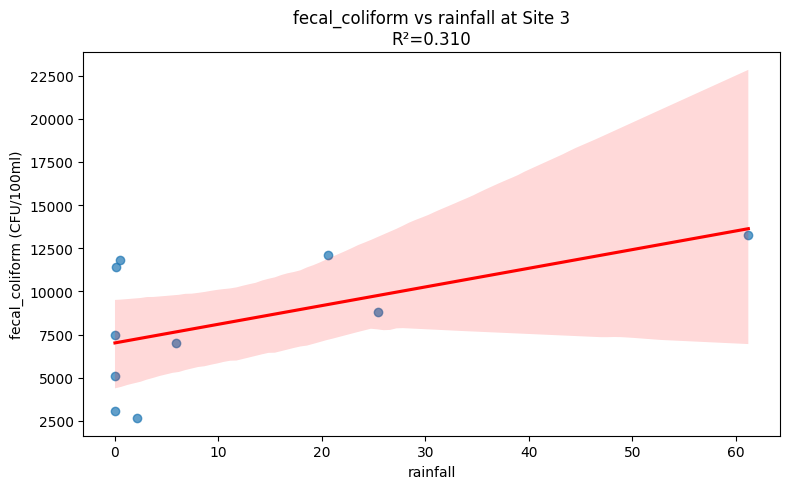

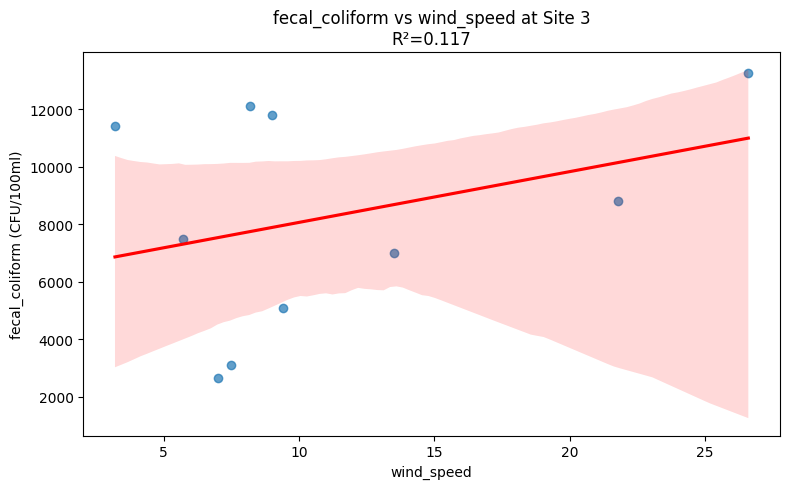

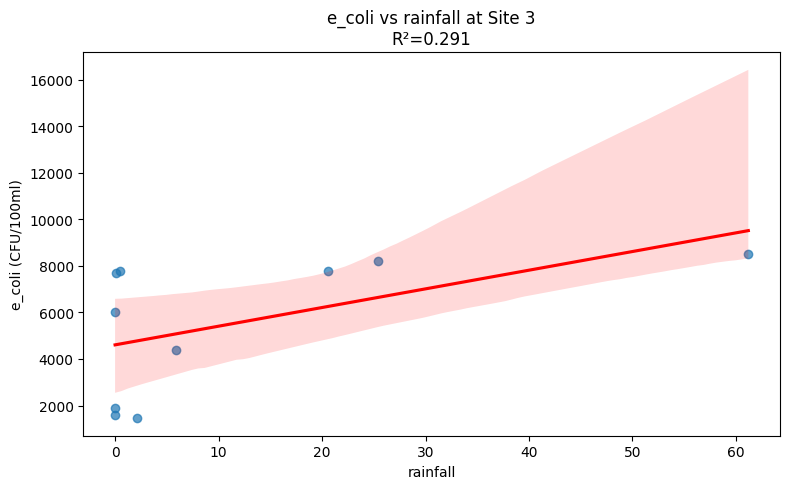

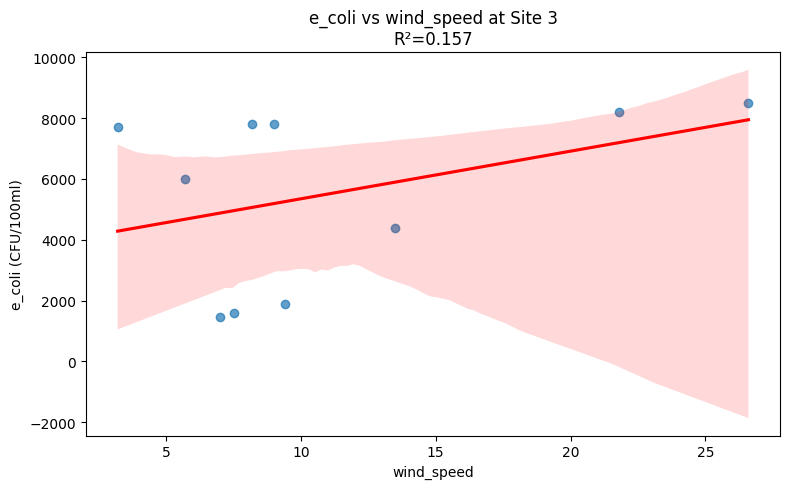

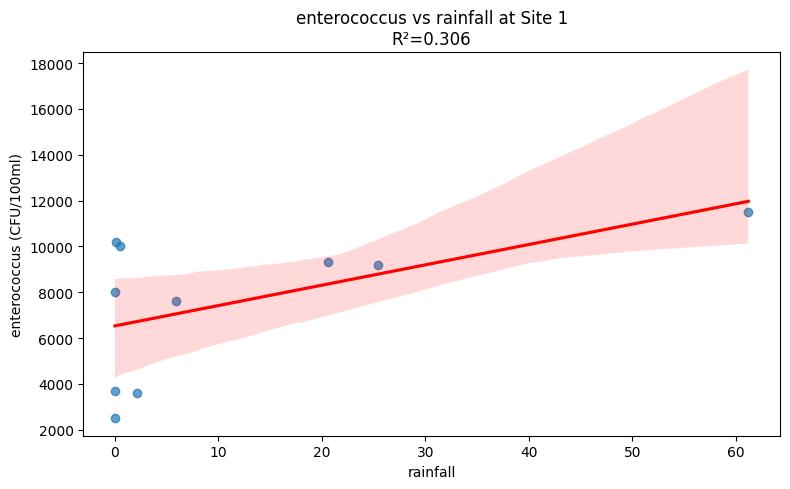

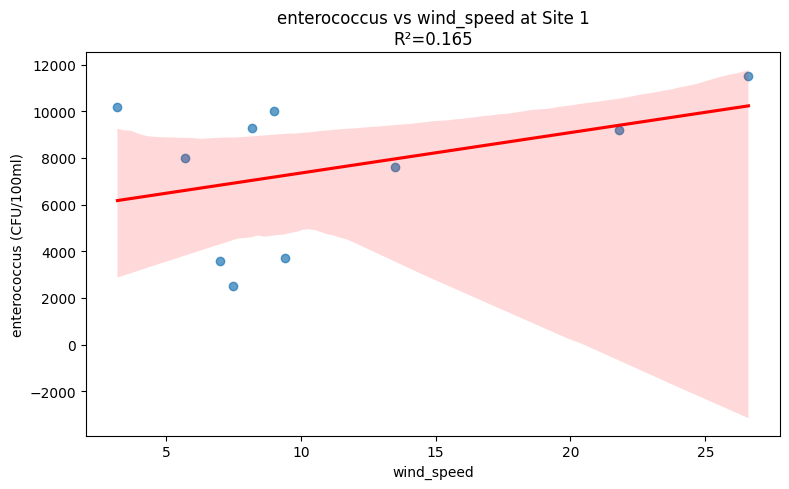

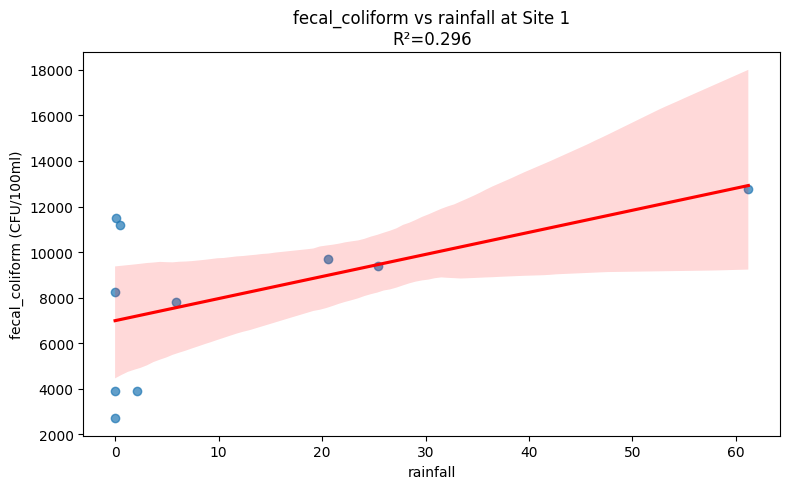

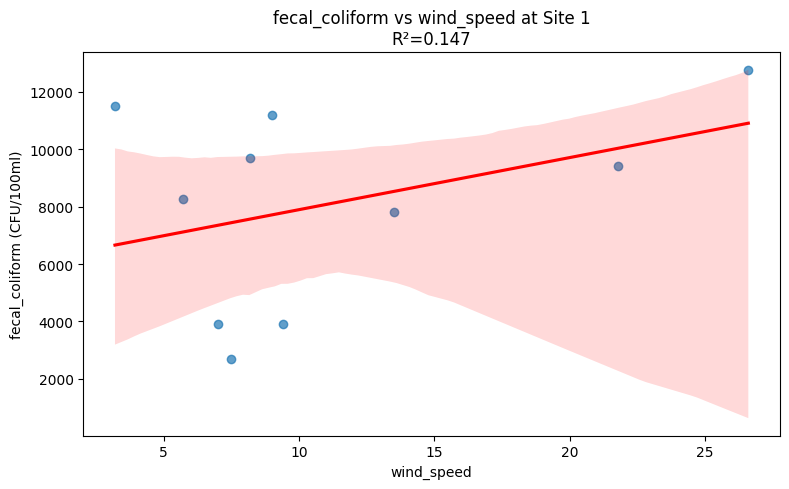

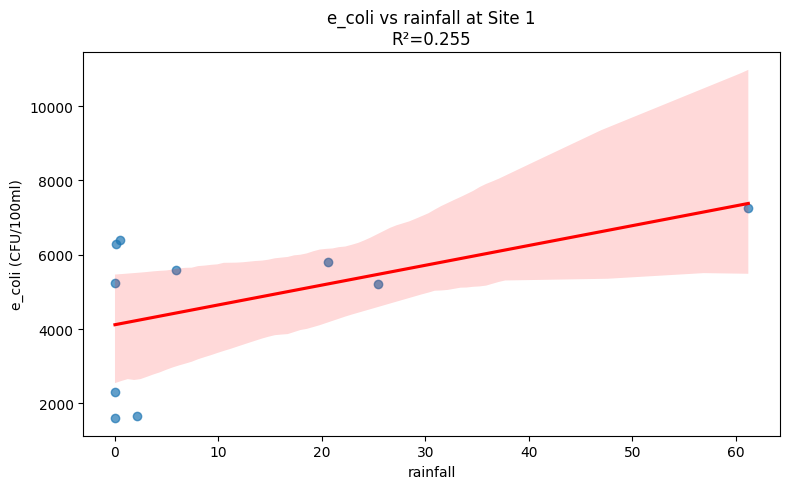

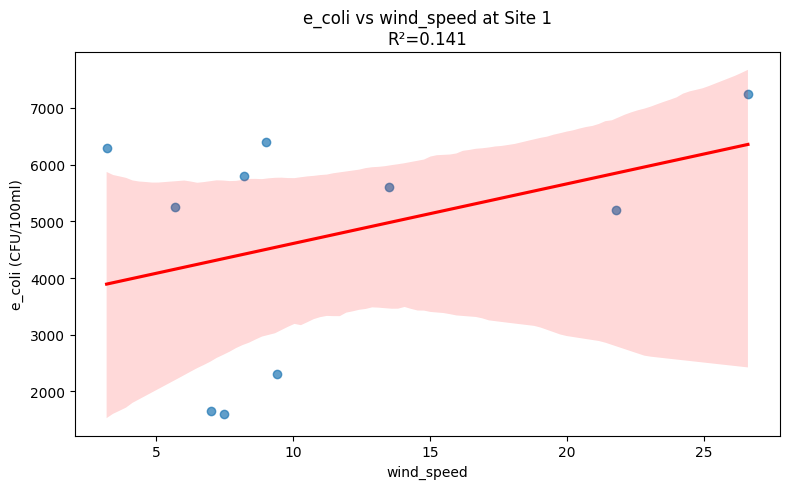

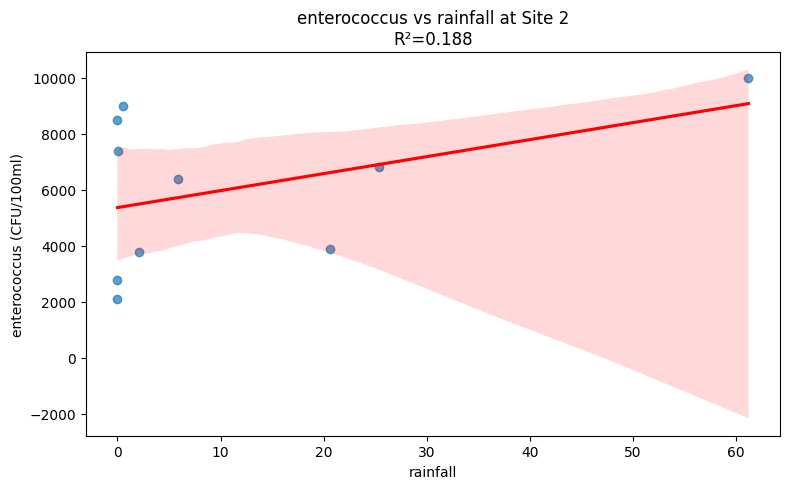

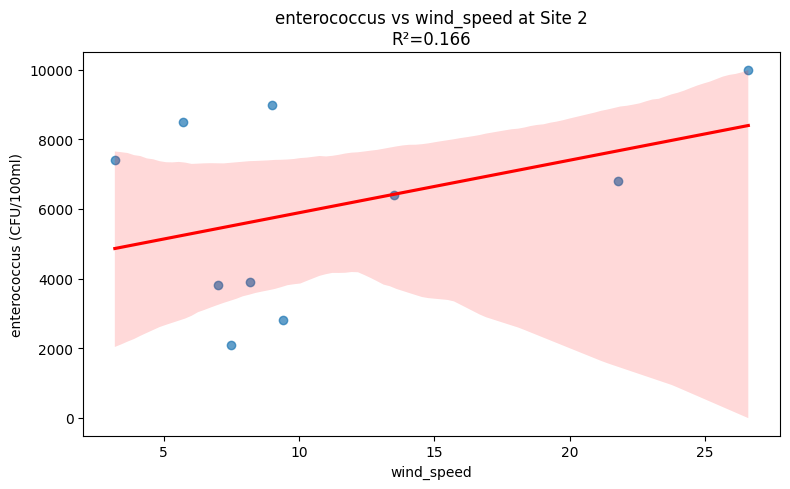

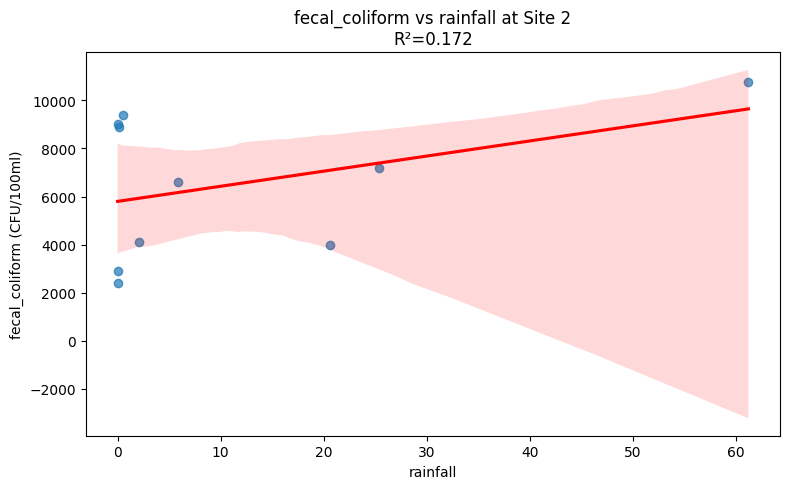

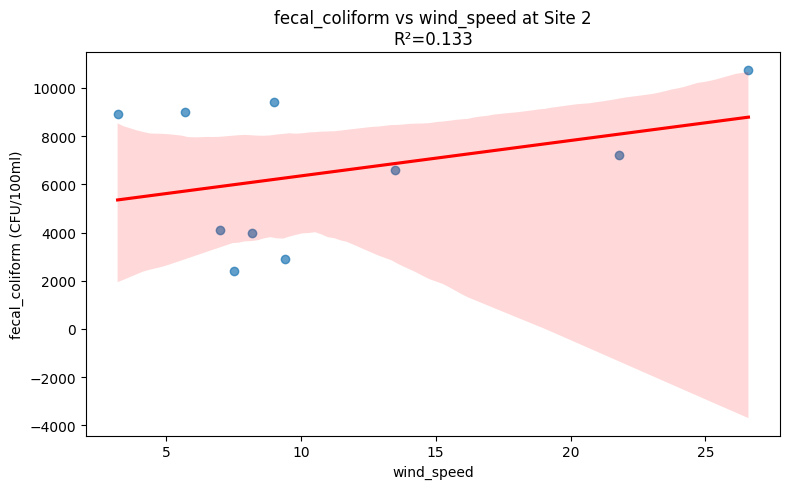

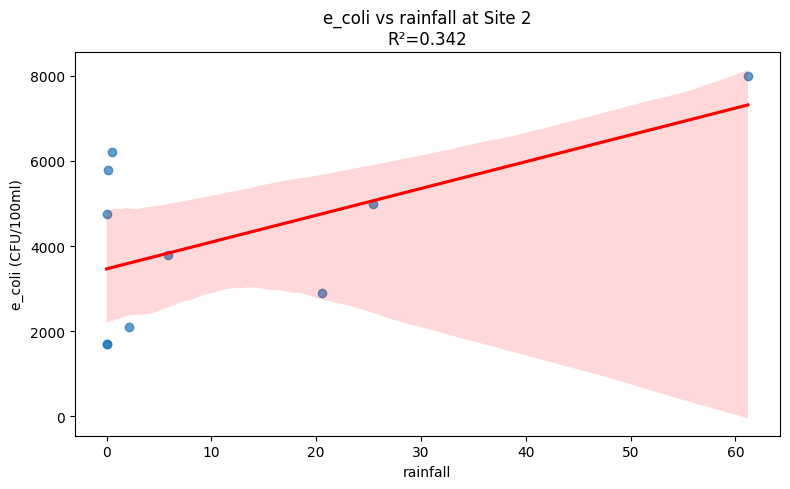

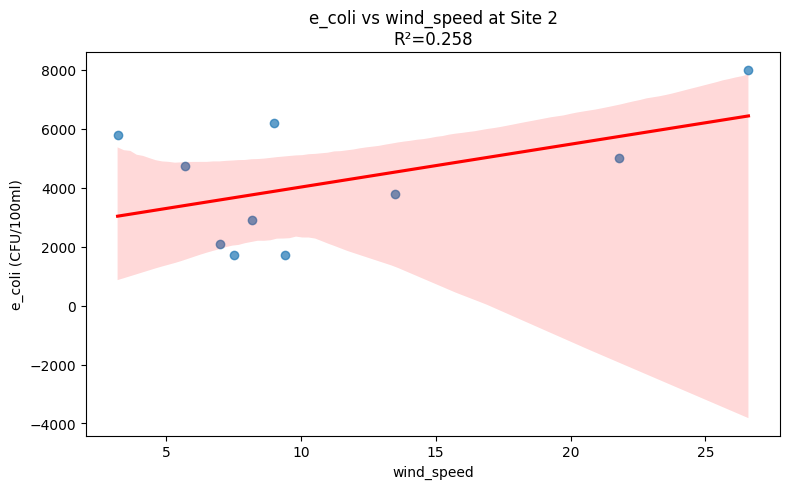

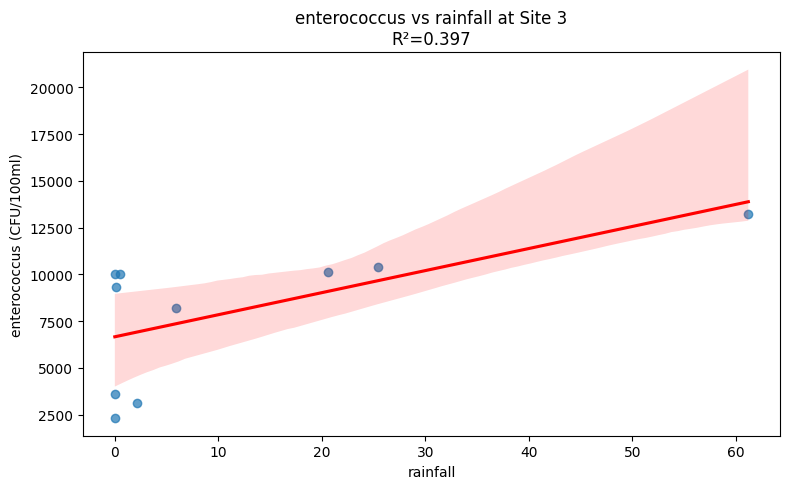

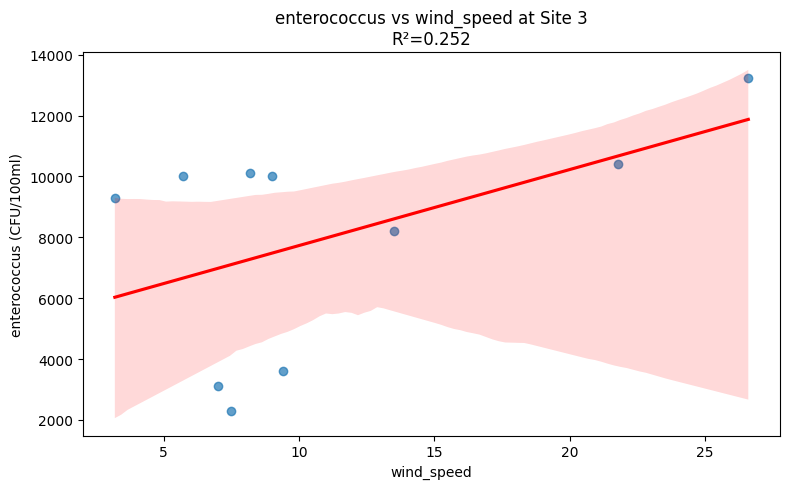

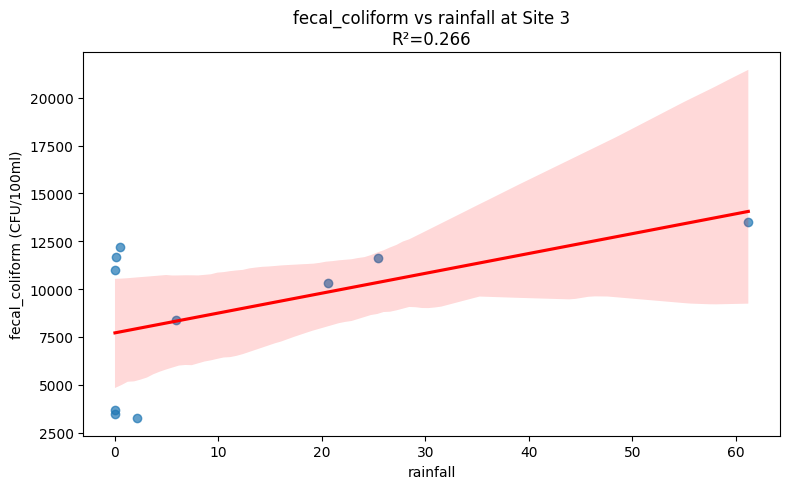

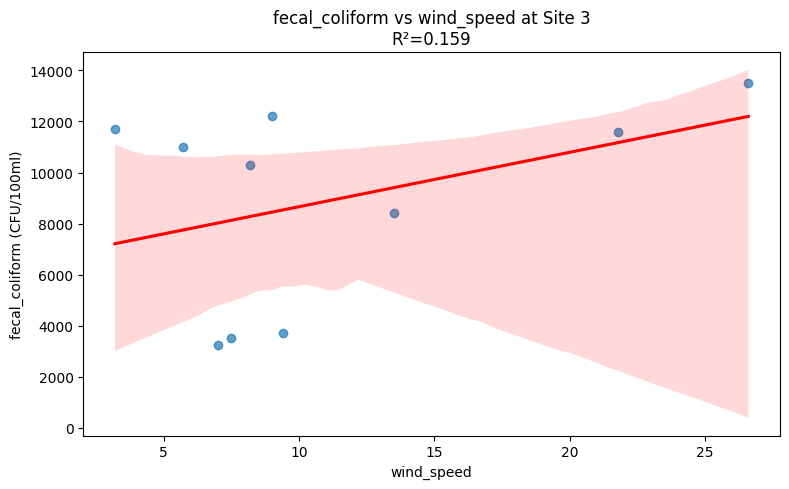

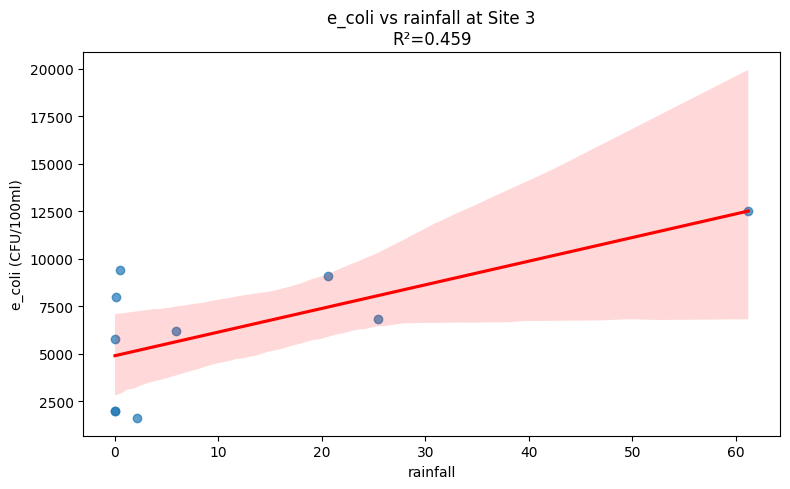

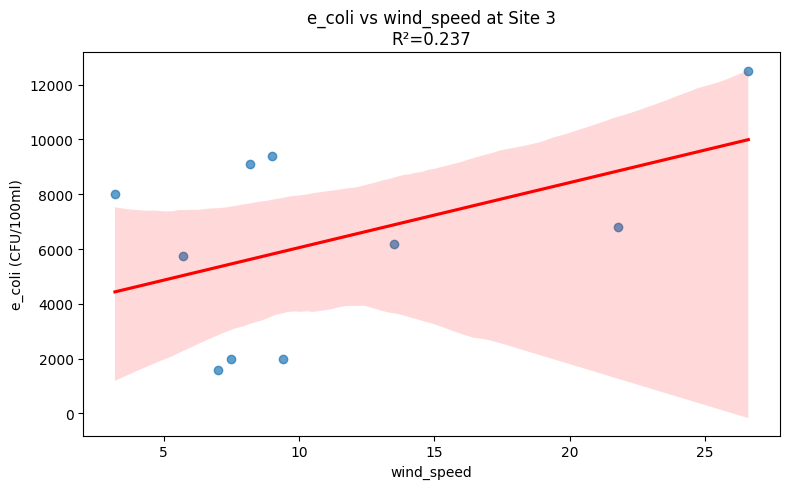

In [ ]:
def site_specific_regression(df, sample_type):
    results = []
    bacteria = ['enterococcus', 'fecal_coliform', 'e_coli']
    factors = ['rainfall', 'wind_speed'] ## add  'ph', 'conductivity', 'salinity', 'temperature' if need to do regression analysis for this pps

    for site in df['site'].unique():
        site_df = df[df['site'] == site]

        for bacterium in bacteria:
            for factor in factors:
                # simple Linear Regression
                X = site_df[[factor]]
                y = site_df[bacterium]

                # skip if not enough data
                if len(X) < 2:
                    continue

                # using sklearn library for basic regression model
                lr = LinearRegression()
                lr.fit(X, y)
                r2 = lr.score(X, y)

                # statsmodels for detailed statistics
                X_sm = sm.add_constant(X)
                sm_model = sm.OLS(y, X_sm).fit()

                # store results
                results.append({
                    'sample_type': sample_type,
                    'site': site,
                    'bacterium': bacterium,
                    'factor': factor,
                    'coefficient': lr.coef_[0],
                    'intercept': lr.intercept_,
                    'r_squared': r2,
                    'p_value': sm_model.pvalues[factor],
                    'n_observations': len(X)
                })

                # plotting
                plt.figure(figsize=(8, 5))
                sns.regplot(x=factor, y=bacterium, data=site_df,
                            line_kws={'color': 'red'}, scatter_kws={'alpha': 0.7})
                plt.title(f'{bacterium} vs {factor} at {site}\nR²={r2:.3f}')
                plt.ylabel(f'{bacterium} (CFU/100ml)')
                plt.tight_layout()
                plt.show()
                # plt.savefig(os.path.join(output_dir, f'{sample_type}_{site}_{bacterium}_vs_{factor}.png'))
                # plt.close()

    return pd.DataFrame(results)

# run for both sample types
sea_site_results = site_specific_regression(seawater, 'sea_water')
sand_site_results = site_specific_regression(sand, 'sand')
site_results = pd.concat([sea_site_results, sand_site_results])
# print(site_results)

### averaged (using weekly mean) Regression Analysis

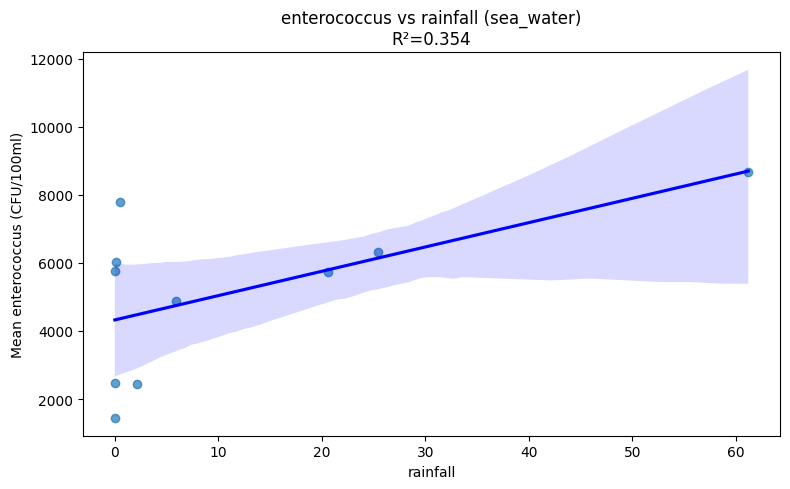

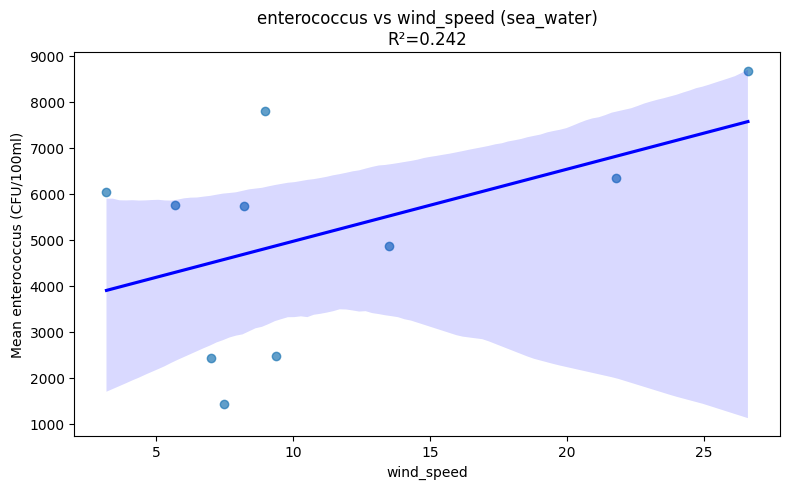

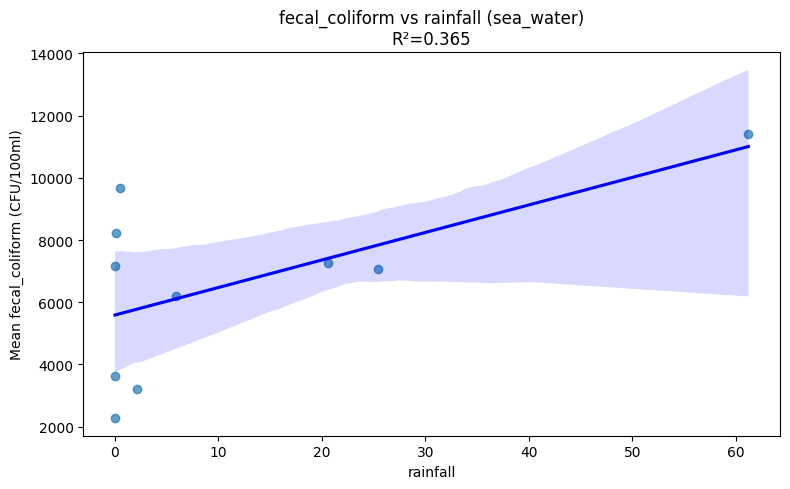

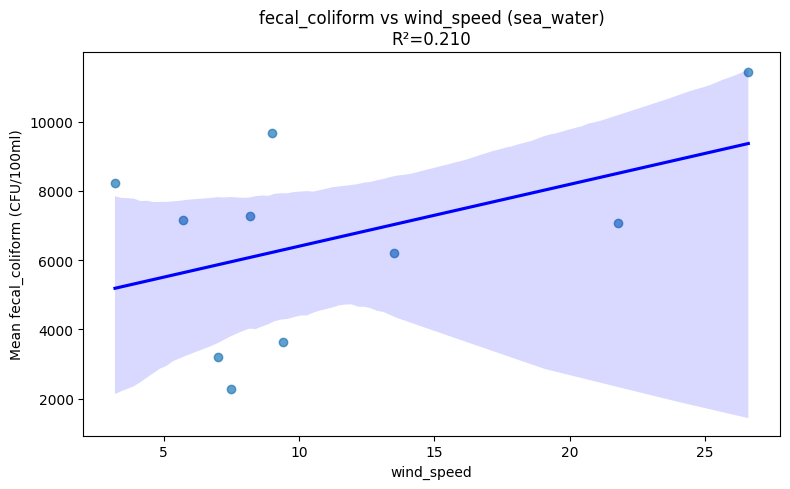

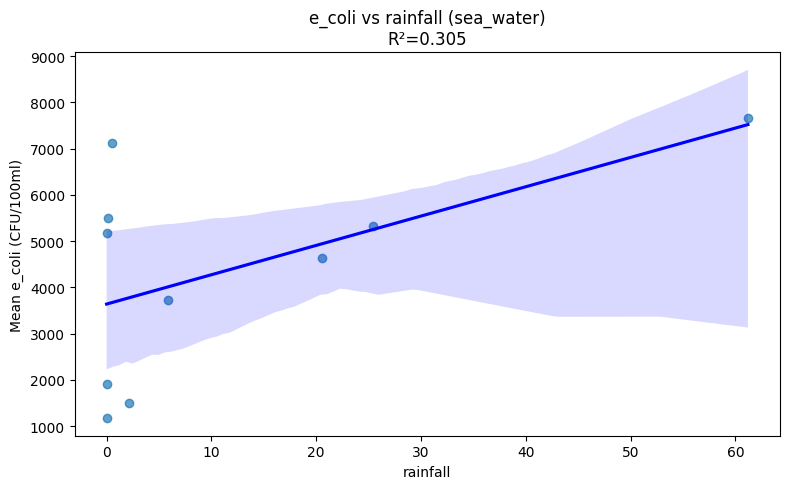

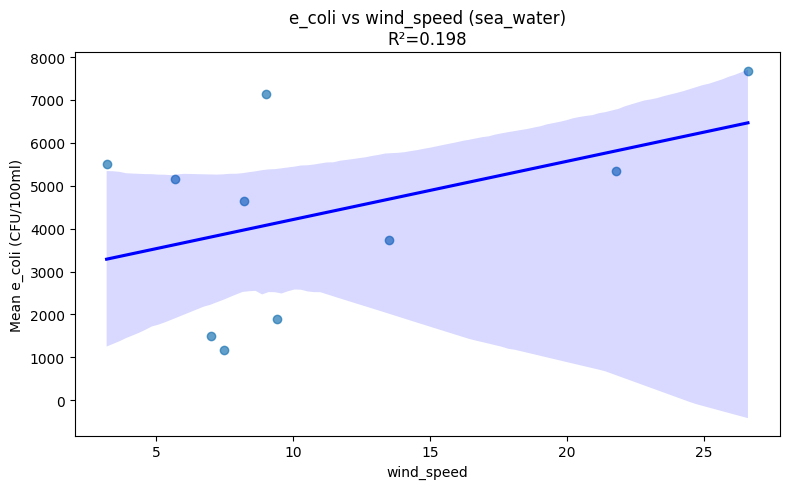

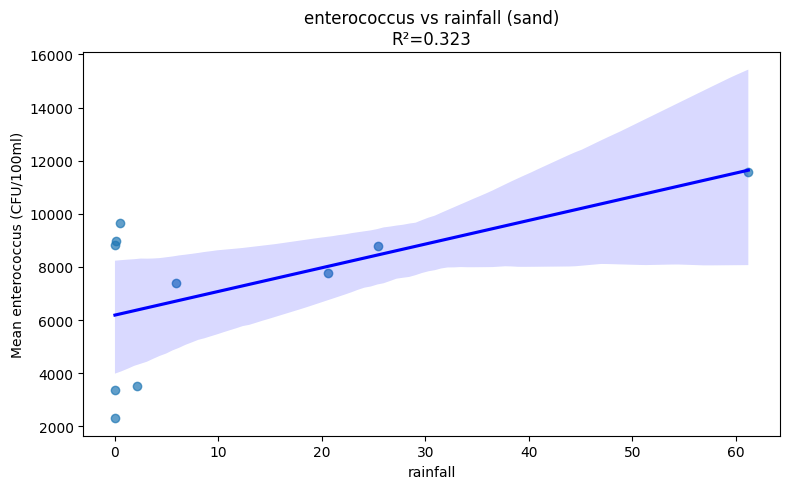

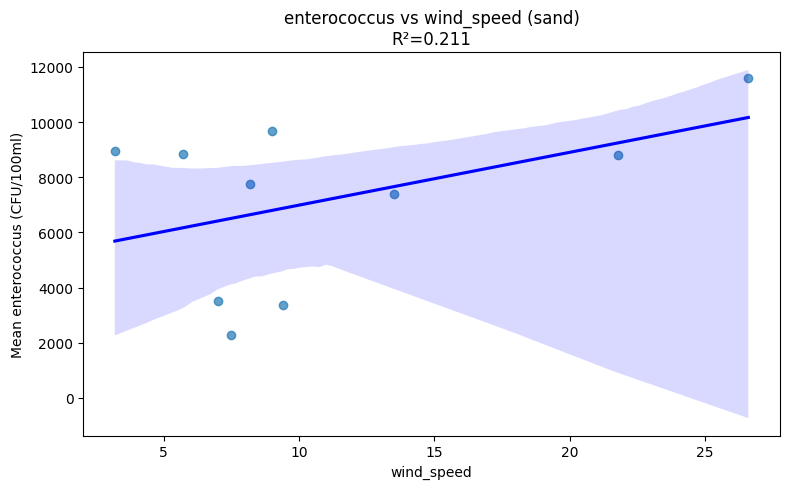

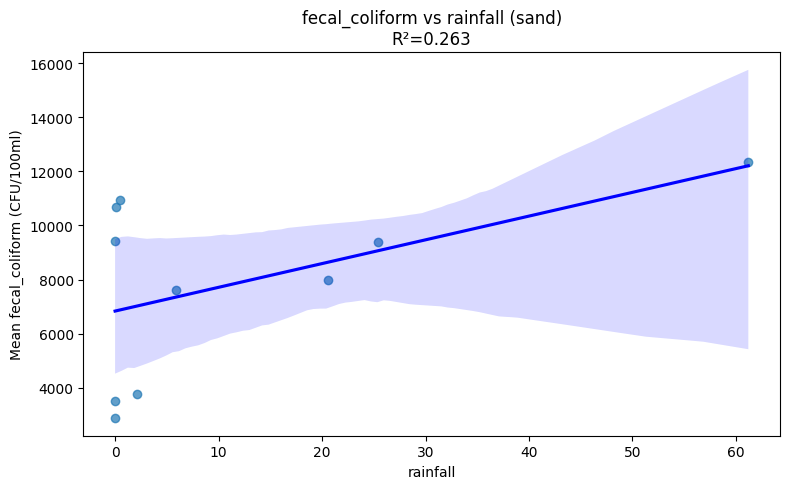

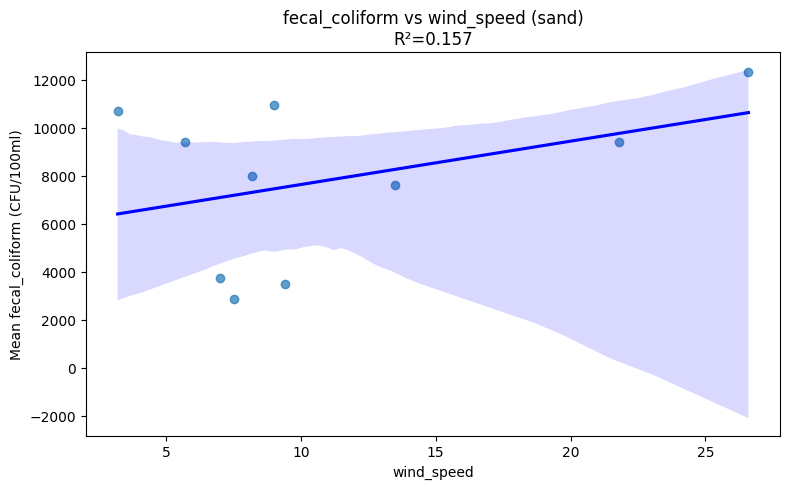

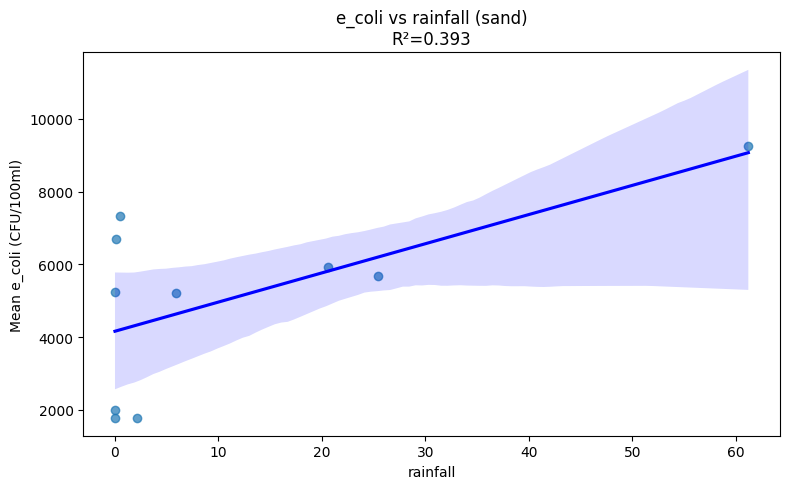

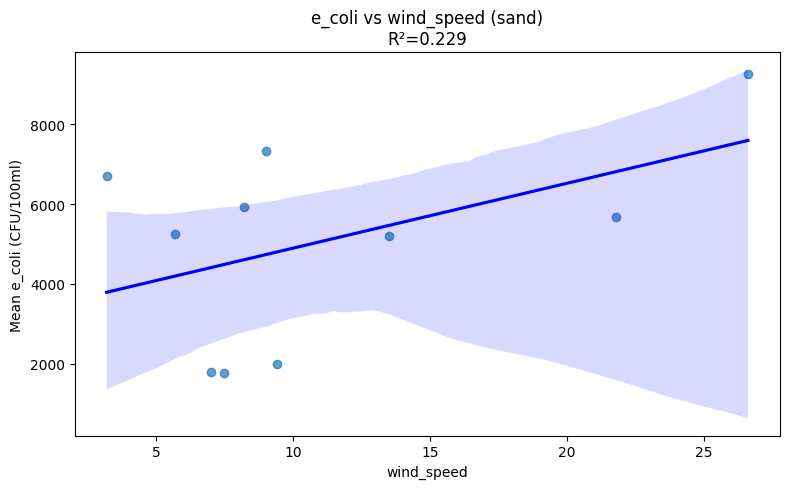

     sample_type       bacterium      factor  coefficient    intercept  \
0  sea_water_avg    enterococcus    rainfall    71.478217  4323.948914   
1  sea_water_avg    enterococcus  wind_speed   156.981641  3395.042103   
2  sea_water_avg  fecal_coliform    rainfall    88.531794  5588.135159   
3  sea_water_avg  fecal_coliform  wind_speed   178.620175  4614.573571   
4  sea_water_avg          e_coli    rainfall    63.462698  3638.435289   
5  sea_water_avg          e_coli  wind_speed   135.842300  2853.257992   
0       sand_avg    enterococcus    rainfall    89.162508  6185.831486   
1       sand_avg    enterococcus  wind_speed   191.472902  5075.751554   
2       sand_avg  fecal_coliform    rainfall    87.828027  6832.951442   
3       sand_avg  fecal_coliform  wind_speed   180.386450  5831.475630   
4       sand_avg          e_coli    rainfall    80.203385  4159.578140   
5       sand_avg          e_coli  wind_speed   162.724712  3267.443801   

   r_squared   p_value  n_observation

In [ ]:
def averaged_regression(df, sample_type):
    results = []

    # Calculate weekly means across sites
    mean_df = df.groupby('week').agg({
        'enterococcus': 'mean',
        'fecal_coliform': 'mean',
        'e_coli': 'mean',
        'rainfall': 'mean',
        'wind_speed': 'mean',
        'ph': 'mean',
        'conductivity': 'mean',
        'salinity': 'mean',
        'temperature': 'mean'
    }).reset_index()

    bacteria = ['enterococcus', 'fecal_coliform', 'e_coli']
    factors = ['rainfall', 'wind_speed'] ## add if needed 'ph', 'conductivity', 'salinity', 'temperature'

    for bacterium in bacteria:
        for factor in factors:
            # prepare data
            X = mean_df[[factor]]
            y = mean_df[bacterium]

            # regression
            lr = LinearRegression()
            lr.fit(X, y)
            r2 = lr.score(X, y)

            # statsmodels
            X_sm = sm.add_constant(X)
            sm_model = sm.OLS(y, X_sm).fit()

            # store results
            results.append({
                'sample_type': f'{sample_type}_avg',
                'bacterium': bacterium,
                'factor': factor,
                'coefficient': lr.coef_[0],
                'intercept': lr.intercept_,
                'r_squared': r2,
                'p_value': sm_model.pvalues[factor],
                'n_observations': len(X)
            })

            # plotting
            plt.figure(figsize=(8, 5))
            sns.regplot(x=factor, y=bacterium, data=mean_df,
                        line_kws={'color': 'blue'}, scatter_kws={'alpha': 0.7})
            plt.title(f'{bacterium} vs {factor} ({sample_type})\nR²={r2:.3f}')
            plt.ylabel(f'Mean {bacterium} (CFU/100ml)')
            plt.tight_layout()
            plt.show()
            # plt.savefig(os.path.join(output_dir_avg, f'{sample_type}_avg_{bacterium}_vs_{factor}.png'))
            # plt.close()

    return pd.DataFrame(results)

# run for both sample types
sea_avg_results = averaged_regression(seawater, 'sea_water')
sand_avg_results = averaged_regression(sand, 'sand')
avg_results = pd.concat([sea_avg_results, sand_avg_results])
print(avg_results)

# combine all results


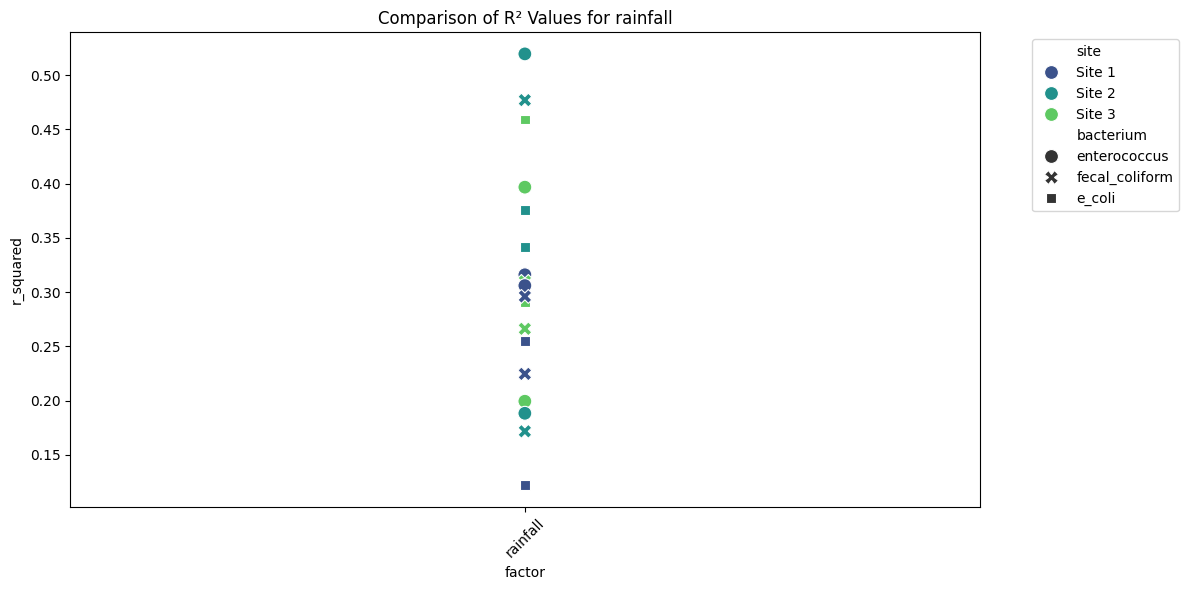

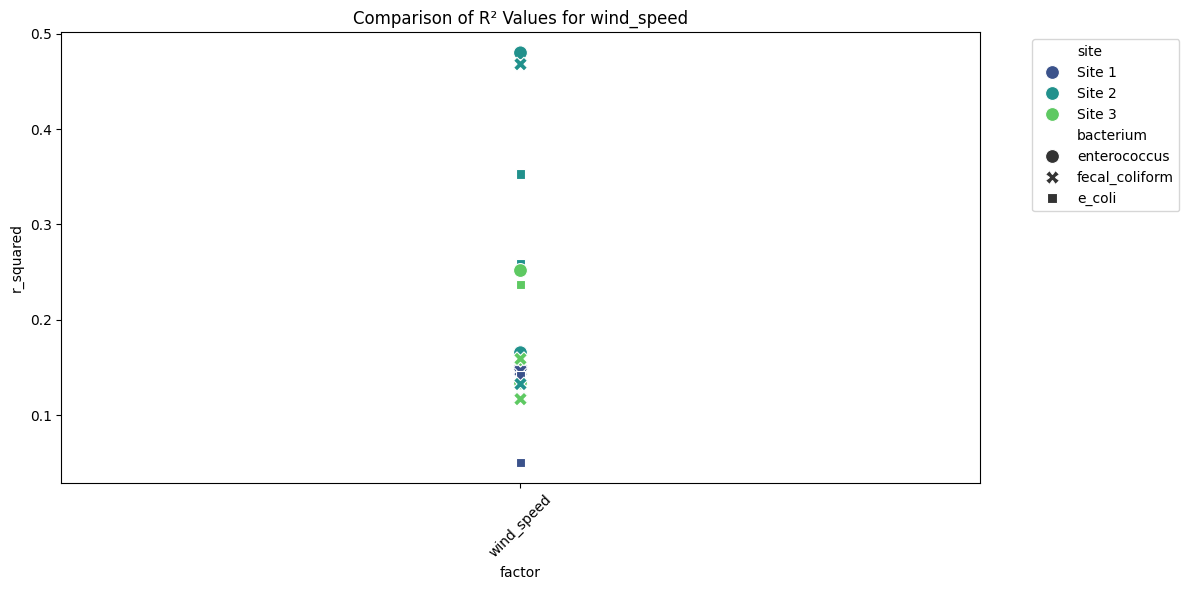

Analysis completed! Results saved in 'regression_results and regression_results_avg' folders.


In [ ]:
all_results = pd.concat([site_results, avg_results])

# save to Excel with multiple sheets
with pd.ExcelWriter('regression_results/regression_analysis.xlsx') as writer:
    site_results.to_excel(writer, sheet_name='Site_Specific', index=False)
    avg_results.to_excel(writer, sheet_name='Weekly_Averaged', index=False)

    # create summary sheets
    summary = all_results.groupby(['sample_type', 'bacterium', 'factor']).agg({
        'r_squared': ['mean', 'max', 'min'],
        'coefficient': ['mean', 'max', 'min'],
        'p_value': lambda x: sum(x < 0.05)/len(x)  # proportion significant
    })
    summary.to_excel(writer, sheet_name='Summary_Statistics')

# comparative Visualization
def plot_comparison(results_df, factor):
    plt.figure(figsize=(12, 6))

    # site-specific results
    site_data = results_df[~results_df['sample_type'].str.contains('averaged')]
    sns.scatterplot(data=site_data, x='factor', y='r_squared', hue='site',
                    style='bacterium', s=100, palette='viridis')

    # averaged results
    avg_data = results_df[results_df['sample_type'].str.contains('averaged')]
    for bacterium in avg_data['bacterium'].unique():
        sub_data = avg_data[avg_data['bacterium'] == bacterium]
        plt.scatter(x=sub_data['factor'], y=sub_data['r_squared'],
                   marker='*', s=200, label=f'Avg {bacterium}')

    plt.title(f'Comparison of R² Values for {factor}')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # plt.savefig(f'regression_results/comparison_{factor}.png')
    plt.show()
    # plt.close()

# generate comparison plots for each factor
for factor in ['rainfall', 'wind_speed']:
    plot_comparison(all_results[all_results['factor'] == factor], factor)

print("Analysis completed! Results saved in 'regression_results and regression_results_avg' folders.")